### Clone Dataset & Supporting Files

In [ ]:
!git clone https://github.com/Autonoship/Data-Augmentation

Cloning into 'Data-Augmentation'...
remote: Enumerating objects: 3616, done.
remote: Counting objects: 100% (3616/3616), done.
remote: Compressing objects: 100% (3404/3404), done.
remote: Total 3616 (delta 210), reused 3616 (delta 210), pack-reused 0
Receiving objects: 100% (3616/3616), 9.50 MiB | 32.54 MiB/s, done.
Resolving deltas: 100% (210/210), done.


In [ ]:

# if you run this ipynb in colab, then run below codes
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing Libraries

In [ ]:
#Importing suppourtive libraries for this task
import os
import numpy as np
import pandas as pd
from PIL import Image
from time import time
from matplotlib import pyplot as plt
from IPython.display import display
import os
import json


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
from pathlib import Path
# choose gpu to train the model otherwise use cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using:', device)

Using: cpu


### Define Datasets and Dataloaders

In [ ]:
#  change the pathes if you don't run this ipynb in colab
dataset_path = '/content/Data-Augmentation/Datasets'
model_path = '/content/Data-Augmentation/Models'
predict_path = '/content/Data-Augmentation/Predict'

Path(dataset_path).mkdir(parents=True, exist_ok=True)
Path(model_path).mkdir(parents=True, exist_ok=True)
Path(predict_path).mkdir(parents=True, exist_ok=True)

Augmenting data with PyTorch is very straightforward. We can use the transforms provided in torchvision: [`torchvision.transforms`](https://pytorch.org/docs/stable/torchvision/transforms.html).

To compose several transforms together, we use [`torchvision.transforms.Compose`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Compose) and pass the transforms as a list. The transforms are applied following the list order.

**Important note**

For training we should probably also add [`transforms.ToTensor`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.ToTensor) to convert the images to a PyTorch Tensor and [`transforms.Normalize`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize) to normalize the images according to the network that you will train. Often times Image Normalization is used to remove noise from the picture (data). With the help of Image Normalization, we can remove high-frequency noise and very low noise from the image which is really helpful.


In [ ]:
# Transformations are used in our Defect-Detection application
transform_1 = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # transform RGB(3 channels) images to grayscale(1 channel) images 
    transforms.Resize((64,64)), # resize the input image to 64*64
    transforms.ToTensor(), # convert image to pytorch tensor

])


# Transformation function to be applied on images
# 1. transform RGB(3 channels) images to grayscale(1 channel) images
# 2. resize the input image to 64*64
# 3. Horizontally Flip the image with a probability of 30%
# 4. Randomly Rotate the image at an angle between -40 to 40 degrees.
# 5. Change the brightness and contrast of an image.
# 6. Convert Image to a Pytorch Tensor(pixel values range from 0 to 1)
# 7. Normalize the pytorch's tensor using mean & std 

mean = torch.tensor([0.5], dtype=torch.float32)
std = torch.tensor([0.5], dtype=torch.float32)

transform_2 = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=40),
    transforms.ColorJitter(brightness =.05, contrast =.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Create a dataset from the dataset folder
# change 'transform=' to choose different transformers(1 or 2)
dataset = torchvision.datasets.ImageFolder(dataset_path, transform=transform_2)

n = len(dataset)  # how many total images you have
n_test = int( n * .2 )  # number of testing images
n_train = n - n_test # number of traing images
print('traing data size:',n_train)
print('testing data size:',n_test)
# Split the dataset into train & test containing 80% and 20% images respectively.
train_dataset, test_dataset = torch.utils.data.random_split(dataset, (n_train, n_test))

# Create a Train DataLoader using Train Dataset
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4
)
# Create a Test DataLoader using Test Dataset
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4
)

traing data size: 2880
testing data size: 720


### Plot Some Samples of data

In [ ]:
figsize = (16,16)

def PlotSamples(dataloader, title='Images'):
    sample_data = next(iter(dataloader))[0].to(device)
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.title(title)
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        sample_data, padding=2, normalize=True
    ).cpu(), (1,2,0)))
    
    
def PlotClass(dataloader, mclass, title='Images', num=32):
    ret = []
    
    for data in dataloader.dataset:
        if data[1] == mclass:
            ret.append(data[0])
            
            if len(ret) == num:
                break
    
    plt.figure(figsize=figsize)
    plt.axis('off')
    title="Class"+ str(mclass)
    plt.title(title)
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        ret, padding=2, normalize=True
    ).cpu(), (1,2,0)))
    

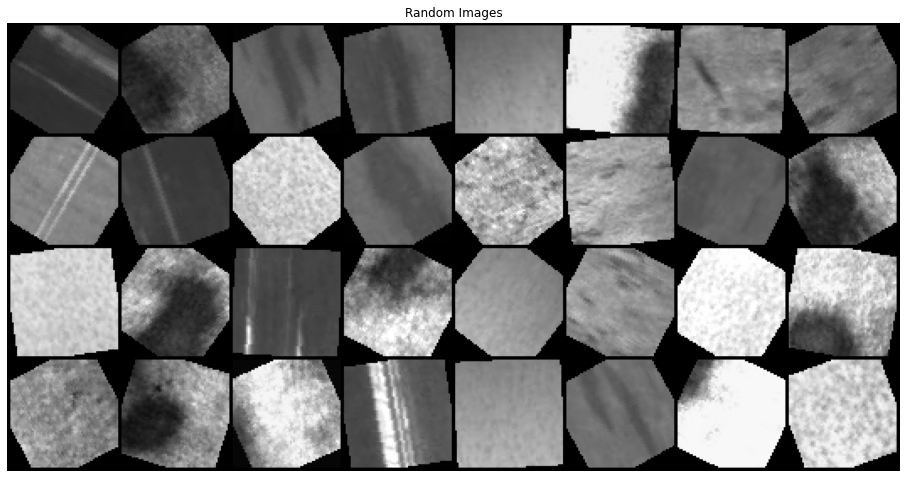

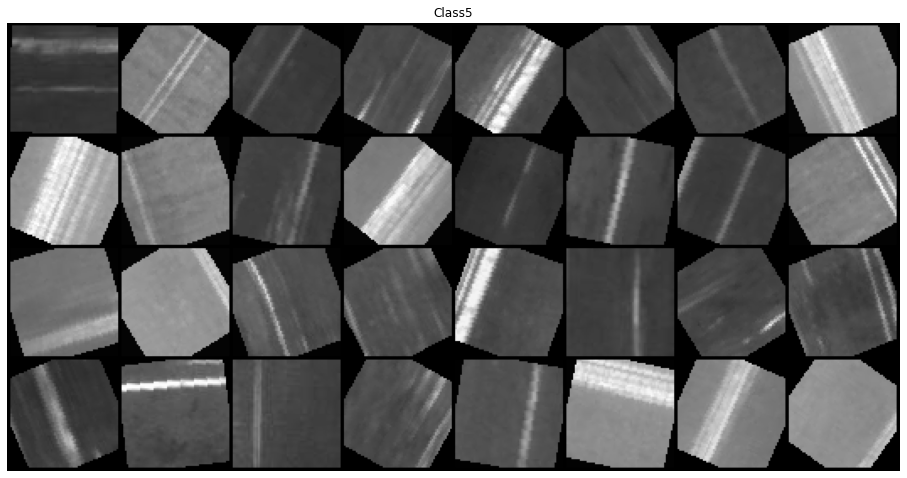

In [ ]:
# randomly show some images in the training dataset
PlotSamples(train_dataloader, title="Random Images")
# show class #5 images in the training dataset
PlotClass(train_dataloader,5)

In [ ]:
classes = []
for d in os.listdir(dataset_path):
    if os.path.isdir(os.path.join(dataset_path, d)) and not d.startswith('.'):
        classes.append(d) 
print ("There are ", len(classes), "classes:\n", classes)

There are  6 classes:
 ['RS', 'Inclusion', 'Crazing', 'Patches', 'Pitted Surface', 'Scratch']


### Defile Model Architecture from Scratches

In [ ]:
# Convolutional neural network from scratches

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3), 
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16, 32, kernel_size=3), 
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size=3), 
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        ).to(device)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(2304, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 6)
        ).to(device)
        
    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x


model = MyModel().to(device)
summary(model, (1,64,64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]             160
              ReLU-2           [-1, 16, 62, 62]               0
         MaxPool2d-3           [-1, 16, 31, 31]               0
            Conv2d-4           [-1, 32, 29, 29]           4,640
              ReLU-5           [-1, 32, 29, 29]               0
         MaxPool2d-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 64, 12, 12]          18,496
              ReLU-8           [-1, 64, 12, 12]               0
         MaxPool2d-9             [-1, 64, 6, 6]               0
          Flatten-10                 [-1, 2304]               0
          Dropout-11                 [-1, 2304]               0
           Linear-12                  [-1, 256]         590,080
             ReLU-13                  [-1, 256]               0
          Dropout-14                  [

### Training Procedure

In [ ]:
def Train(epoch, steps):
    total_loss = 0
    start_time = time()
    
    accuracy = []
    
    for i, batch in enumerate(train_dataloader, 1):
        minput = batch[0].to(device) # Get batch of images from our train dataloader
        target = batch[1].to(device) # Get the corresponding target representing types of defects
        moutput = model(minput) # output by our model
        loss = criterion(moutput, target) # compute cross entropy loss
        total_loss += loss.item()
        optimizer.zero_grad() # Clear the gradients if exists. (Gradients are used for back-propogation.)
        loss.backward() # Back propogate the losses
        optimizer.step() # Update Model parameters
        
        argmax = moutput.argmax(dim=1) # Get the class index (exp: 0, 1, 2, 3, 4 or 5) with maximum probability predicted by the model
        accuracy.append((target==argmax).sum().item() / target.shape[0]) # calculate accuracy by comparing to target tensor
        # show loss and acc during training
        if i%steps == 0:
            print('Epoch: [{}]/({}/{}), Train Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
                epoch, i, len(train_dataloader), loss.item(), sum(accuracy)/len(accuracy), time()-start_time 
            ))
    
    return [total_loss / len(train_dataloader),sum(accuracy)/len(accuracy)]  # Returning Average Training Loss and Accuracy

### Testing Procedure

In [ ]:
def Test(epoch):
    total_loss = 0
    start_time = time()

    accuracy = []
    
    with torch.no_grad(): # disable calculations of gradients for all pytorch operations inside the block
        for i, batch in enumerate(test_dataloader):
            minput = batch[0].to(device) # Get batch of images from our test dataloader
            target = batch[1].to(device) # Get the corresponding target representing types of defects
            moutput = model(minput) # output by our model
            loss = criterion(moutput, target) # compute cross entropy loss
            total_loss += loss.item()

            # To get the probabilities for different classes we need to apply a softmax operation on moutput 
            argmax = moutput.argmax(dim=1) # Find the index(exp: 0, 1, 2, 3, 4 or 5) with maximum score (which denotes class with maximum probability)
            accuracy.append((target==argmax).sum().item() / target.shape[0]) # Find the accuracy of the batch by comparing it with actual targets
            
    print('Epoch: [{}], Test Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
        epoch, total_loss/len(test_dataloader), sum(accuracy)/len(accuracy), time()-start_time
    ))
    return [total_loss/len(test_dataloader), sum(accuracy)/len(accuracy)] # Returning Average Testing Loss and Accuracy

### Model, Optimizer & Loss Function

In [ ]:
lr = 0.0001
model = MyModel().to(device)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# Loss Function
criterion = nn.CrossEntropyLoss()

### Train for 50 epochs

In [ ]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []
# change the numbers of the range to choose how many epochs to train the model
for epoch in range(1, 51):
# '90' is the number of steps,as the batch size is 32 and the training data size is 2880
    train = Train(epoch,90)
    test = Test(epoch)
    train_loss.append(train[0])
    test_loss.append(test[0])
    train_acc.append(train[1])
    test_acc.append(test[1])
    print('\n')
    # save trained models every ten epochs
    if epoch % 10 == 0:
        torch.save(model, os.path.join(model_path, str(epoch)+'.pth'))

Epoch: [1]/(90/90), Train Loss: 1.2491, Accuracy: 0.35, Time: 9.80 sec
Epoch: [1], Test Loss: 1.2926, Accuracy: 0.54, Time: 1.42 sec


Epoch: [2]/(90/90), Train Loss: 1.0355, Accuracy: 0.56, Time: 9.61 sec
Epoch: [2], Test Loss: 1.1077, Accuracy: 0.62, Time: 1.41 sec


Epoch: [3]/(90/90), Train Loss: 0.9074, Accuracy: 0.63, Time: 9.54 sec
Epoch: [3], Test Loss: 0.9893, Accuracy: 0.65, Time: 1.43 sec


Epoch: [4]/(90/90), Train Loss: 0.7030, Accuracy: 0.67, Time: 9.53 sec
Epoch: [4], Test Loss: 0.9178, Accuracy: 0.69, Time: 1.42 sec


Epoch: [5]/(90/90), Train Loss: 0.6429, Accuracy: 0.71, Time: 9.59 sec
Epoch: [5], Test Loss: 0.7898, Accuracy: 0.73, Time: 1.46 sec


Epoch: [6]/(90/90), Train Loss: 0.5760, Accuracy: 0.75, Time: 9.86 sec
Epoch: [6], Test Loss: 0.7028, Accuracy: 0.75, Time: 1.45 sec


Epoch: [7]/(90/90), Train Loss: 0.5712, Accuracy: 0.78, Time: 9.59 sec
Epoch: [7], Test Loss: 0.6486, Accuracy: 0.78, Time: 1.43 sec


Epoch: [8]/(90/90), Train Loss: 0.3919, Accuracy: 0.79,

### Plot Train-Test Loss Curve

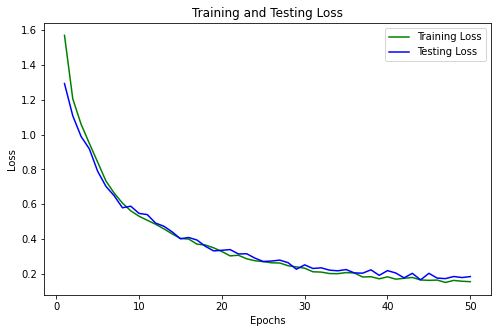

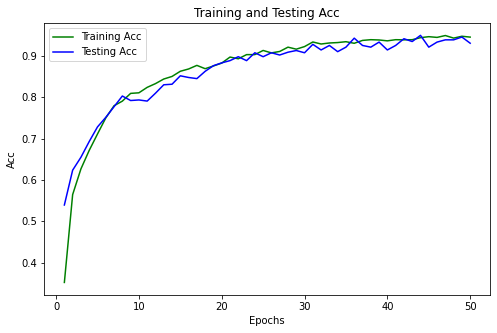

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_loss)+1), train_loss, 'g', label='Training Loss')
plt.plot(range(1, len(test_loss)+1), test_loss, 'b', label='Testing Loss')

plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_acc)+1), train_acc, 'g', label='Training Acc')
plt.plot(range(1, len(test_acc)+1), test_acc, 'b', label='Testing Acc')

plt.title('Training and Testing Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

### Test on some random images

In [ ]:
translate = {
    "Crazing": "crazing", 
    "Inclusion": "inclusion", 
    "Patches": "patches", 
    "Pitted Surface": "pitted surface", 
    "RS": "rolled-in scale", 
    "Scratch": "scratches", 
}

translate = {x:translate[x] for x in train_dataloader.dataset.dataset.classes}
print(translate)

{'Crazing': 'crazing', 'Inclusion': 'inclusion', 'Patches': 'patches', 'Pitted Surface': 'pitted surface', 'RS': 'rolled-in scale', 'Scratch': 'scratches'}


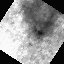

patches : 99 % 




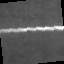

scratches : 99 % 




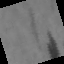

inclusion : 83 % 




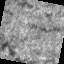

crazing : 99 % 




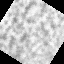

pitted surface : 99 % 




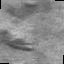

rolled-in scale : 95 % 




In [ ]:
# # Uncomment the below two lines if you want to use the pre trained model for more epochs
# model = torch.load('./model_name.pth', map_location=device)
# model.eval()

denormalize = transforms.Compose([
    transforms.Normalize(mean = -mean/std, std = 1./std),
    transforms.ToPILImage()
])


with torch.no_grad(): # disable calculations of gradients for all pytorch operations inside the block

    for impath in os.listdir(predict_path):
        
        try:
            image = Image.open(os.path.join(predict_path, impath))
            
        except:
            continue
        # choose transform_1 or transform_2 to tranform input image
        image = transform_2(image)
        image_tensor = image.view(1,1,64,64).to(device)
        moutput = model(image_tensor)
        moutput = nn.Softmax(dim=1)(moutput)[0]*100
        idx = moutput.argmax().data.item()
        oclass = list(translate.keys())[idx]
        moutput = moutput.int().data.cpu().numpy()
        display(denormalize(image))
        print(translate[oclass], ':', moutput[idx], '%', '\n\n')



# New Section